# A $\chi^2$ Tutorial

In [1]:
from __future__ import print_function
%matplotlib inline
import numpy as np, pylab as plt

Suppose we have a linear function,
\begin{equation}
f(x,m,b)=mx+b,
\end{equation}
that we have measured at various $x_i$'s.  Our measurements are noisy, so for each measurement, $y_i$, that we make, 
we get a sample of the function $f(x_i,m,b)$ added with some noise, $n_i$:
\begin{equation}
y_i=f(x_i,m,b)+n_i,
\end{equation}
For this example, let's assume the noise is drawn from a Gaussian distribution and each measurement has statistically identical noise with a variance of $\langle n_i^2\rangle\equiv\sigma^2$. 

In [2]:
def f(x,m,b):
    return m*x+b

xs = np.array([-2, -1, 0, 1, 2], dtype=np.float)
ys = np.array([-4.0761021 , -0.61376301,  0.96543424,  3.7373177 ,  3.86467818])

So given the measurements, `ys`, at the coordinates specified in `xs`, which would be your best guess for ($m$,$b$)?
- (1,1)
- (2,1)
- (1,2)
- (2,2)

If you have a menu of choices, just evaluate $\chi^2$ for each one:
\begin{equation}
\chi^2=\sum_i{\frac{|y_i-f(\vec x_i,\vec p)|^2}{\sigma_i^2}}.
\end{equation}
In the above equation, $i$ indexes different measurements, $\sigma_i$ is the expected error in each measurment, and we have introduced a vector, $\vec p$, that contains the parameters we are fitting.  In the above example, $\vec p = (m, b)$.

In [3]:
def chisq(ys, mdl, sig):
    return np.sum(np.abs(ys-mdl)**2/sig**2)

sig = 1. # Let's assume \sigma_i^2=1 for now
ps = [(1,1),(2,1),(1,2),(2,2)]
X2 = [chisq(ys, f(xs,*p), sig) for p in ps]
print('Chi-Square:', np.around(X2,2))

Chi-Square: [13.61  3.14 20.85 10.39]


So it appears $(m,b)=(2,1)$ is the best answer! Here's what it looks like.

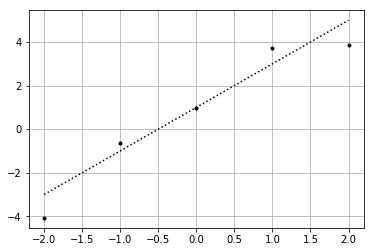

In [4]:
plt.figure()
plt.plot(xs,ys,'k.')
plt.plot(xs, 2*xs+1, 'k:')
plt.grid()
plt.show()

But what happens if we don't have a menu of choices?  Our options are:
- make our own menu (e.g. sample a grid at some resolution), or
- optimize!

In a moment, we will take a trip down the rabbit-hole of optimizing functions, but first, let's ask the reasonable question, "Why $X^2$?".

## Why $\chi^2$?

When fitting a model to data, we are looking for the likeliest (maximum likelihood) solution.  What determines the likelihood, $L$, of a solution?  It is the probability 
that each measurement's deviation from the model could happen by random chance.  Mathematically, this is written
\begin{equation}
L = \prod_i\frac{1}{\sigma_i\sqrt{2\pi}}
e^{-\left|y_i-f(\vec x_i,\vec p)\right|^2/2\sigma_i^2}.
\end{equation}
Don't worry about the $1/\sigma_i\sqrt{2\pi}$ prefactor; that's just a normalization that ensures probabilities add to one.  The important part is the exponential.

We need to maximize $L$, but exponentials are cumbersome. 
Instead, let's maximize $\log L$:
\begin{equation}
\log L = -\frac12\sum_i\frac{\left|y_i-f(\vec x_i,\vec p)\right|^2}{\sigma_i^2} - \sum_i \log(\sigma_i\sqrt{2\pi})
\end{equation}
The second term (with the $\sigma_i\sqrt{2\pi}$) doesn't depend on the model, so we can safely ignore it---it's a constant.  Let's focus on optimizing the first term. To clean things up, we'll drop the $-\frac12$ factor (so now we are *minimizing*), which gives us
\begin{equation}
\chi^2=\sum_i{\frac{|y_i-f(\vec x_i,\vec p)|^2}{\sigma_i^2}}.
\end{equation}

Maximizing $L$ is the same as minimizing $\chi^2$.
Moreover, since $L\propto e^{-\frac12\chi^2}$, $\chi^2$ is a measure of the number of "sigmas" (squared) by which your fit deviates from the model.

## Optimizing $\chi^2$

Optimizing (which in numerics is almost always framed as minimizing) a general function can be done by looping over the following four steps:
1. Start somewhere.  Choose a $\vec p_j$ (the $j^{\rm th}$ successive estimate of the optimal parameters, $\vec p$) and evaluate
\begin{equation}
\chi_j^2=\sum_i{\frac{|y_i-f(\vec x_i,\vec p_j)|^2}{\sigma_i^2}}
\end{equation}
2. Compute the gradient (slope) of $\chi^2$ w.r.t. $p_A,p_B,\dots=\vec p_j$ to get $\frac{\partial\chi^2}{\partial \vec p_j}$
3. Check to see if either $\chi_j^2$ or $\frac{\partial\chi^2}{\partial \vec p_j}$ are small enough to declare victory.  If so, STOP.
4. Otherwise, take a step "downhill" toward your target $\chi^2_T$ and return to step 1:
\begin{align}
\frac{\chi_T^2-\chi_j^2}{\vec p_{j+1}-\vec p_j}&=-\frac{\partial\chi^2}{\partial \vec p_j}\\
\vec p_{j+1} &= \vec p_j - \frac{\chi_T^2-\chi_j^2}{\partial\chi^2/\partial \vec p_j}\\
\end{align}

### Taking a Gradient Numerically

Suppose you have a general function $g(\vec x)$ that you need to take the gradient of:
\begin{equation}
\frac{\partial g}{\partial\vec x}=\left(\frac{\partial g}{\partial x_0}, \frac{\partial g}{\partial x_1}, \frac{\partial g}{\partial x_2}, \dots\right)
\end{equation}

Numerically, this might look like:

In [5]:
def g(x):
    return x[0]**2 + 2*x[1]**4 + np.cos(x[2])

x0,x1,x2 = x = np.array([1.,2,np.pi/2])
g0 = g(x)
#dx = 1e-15 # errors from numerical precision
dx = 1e-5 # good?
#dx = 1e-1 # errors from step size
x0_step = np.array([x0+dx,x1,x2])
x1_step = np.array([x0,x1+dx,x2])
x2_step = np.array([x0,x1,x2+dx])
dg_dx = np.array([(g(x0_step)-g0)/dx, (g(x1_step)-g0)/dx, (g(x2_step)-g0)/dx])
print('g(x) =', g0)
print('dg/dx =', np.around(dg_dx, 2))

g(x) = 33.0
dg/dx = [ 2. 64. -1.]


### Minimizing Functions

If we iterate along, computing gradients, stepping downhill, and recomputing, we can eventually find where (or if) the function's gradient goes to zero, indicating we've minimized it.  However, there is something of an art to taking steps of the right size such that:
- you don't spend forever getting there, but
- you don't overstep, go unstable, and end up at infinity.

Here's an example of a minimizing function:

In [6]:
def minimize(func, xs, stepsize=1e-2, dx=1e-5, maxiter=100, tol=1e-3):
    '''Minimize a function using a gradient-descent algorithm.'''
    for iter in range(maxiter):
        f0 = func(xs)
        ndims = len(xs)
        x_steps = [xs.copy() for i in range(ndims)]
        for i in xrange(ndims):
            x_steps[i][i] += dx
        grad = np.array([(func(x_steps[i])-f0)/dx for i in range(ndims)])
        if np.abs(grad).max() < tol:
            break
        xs = np.array([xs[i]-stepsize*grad[i] for i in range(ndims)])
    return {'iter':iter, 'func':f0, 'grad':grad, 'x':xs}

In [7]:
result = minimize(g, np.array([1.,2,3]), stepsize=.03, maxiter=1000)
print('Solution:', np.around(result['x'],2))
print('Iterations:', result['iter'])

Solution: [-0.    0.05  3.14]
Iterations: 509


In [8]:
result = minimize(g, np.array([1.,2,3]), stepsize=.001, maxiter=1000)
print('Solution:', np.around(result['x'],2))
print('Iterations:', result['iter'])

Solution: [0.14 0.25 3.09]
Iterations: 999


In [9]:
result = minimize(g, np.array([1.,2,3]), stepsize=.1, maxiter=1000)
print('Solution:', np.around(result['x'],2))
print('Iterations:', result['iter'])

Solution: [5.10000000e-01 7.11588315e+15 3.04000000e+00]
Iterations: 4


As you can see, our ability to converge to a reasonable solution can be finicky. Fortunately, there are libraries for this kind of thing:

In [10]:
import scipy.optimize
result = scipy.optimize.fmin(g, np.array([1.,2,3]))
print('Solution:', np.around(result,2))

Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 146
         Function evaluations: 259
Solution: [-0.   -0.    3.14]


### Back to Optimizing $\chi^2$

In [11]:
def chisq_min(p):
    m,b = p
    return chisq(ys, f(xs,m,b), 1.) 

ans = scipy.optimize.fmin(chisq_min, np.array([.5,.5]))
print('m,b =', np.around(ans,2))

Optimization terminated successfully.
         Current function value: 2.883578
         Iterations: 35
         Function evaluations: 67
m,b = [2.02 0.78]


So we've gone and fit `m` and `b` in our `f(x) = m*x+b` example, and now we have an answer.  Is this the actual answer?  What are the statistical errors on these measurements?

And if you were wondering, the above is what `np.polyfit` does, except it's programmed in the gradients analytically, so it converges faster.

In [12]:
m,b = np.polyfit(xs,ys, deg=1)
print('m,b =', m,b)

m,b = 2.0232641269999996 0.7755130020000003


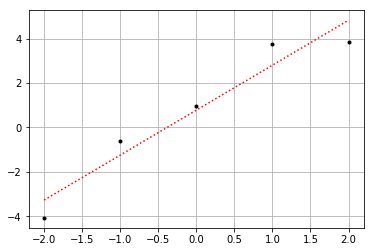

In [13]:
plt.figure()
plt.plot(xs,ys,'k.')
plt.plot(xs, ans[0]*xs+ans[1], 'r:')
plt.grid()
plt.show()

## Estimating Errors

In the above example, it looks like the final $\chi^2$ of our fit was 2.8.  Is this good?
- Yes
- No
- Maybe
- Depends

So the way we've been writing $\chi^2$, it scales with the number of measurements we make:
\begin{equation}
\chi^2=\sum_i{\frac{|y_i-f(\vec c_i,\vec p)|^2}{\sigma_i^2}}
\end{equation}

To make a fair comparison, we need to normalize this to the error we expect in a "perfect" fit.  Suppose we knew $m,b$ perfectly, so that we could subtract $f(x_i,m,b)$ from our measurement $y_i=f(x_i,m,b)+n_i$.  In this case, the residual would be $n_i$, and $\langle|n_i|^2\rangle=\sigma_i^2$.  If we know our $\sigma^2$ well, we can construct a *reduced* $\chi^2$,
\begin{equation}
\chi_r^2=\frac{1}{N}\sum_i{\frac{|y_i-f(\vec c_i,\vec p)|^2}{\sigma_i^2}},
\end{equation}
where we expect $\chi_r^2\approx1$ if we know $\sigma_i$ well enough.

So above, we had $N=5$ measurements, to $\chi_r^2=\chi^2/5=0.58$.  That's a good fit.  Perhaps too good?

## When Fits are "Too Good to be True"

Suppose I have a silly line, $y=0$, and I add some noise to a bunch of measurements of this line, and then fit a line to those measurements and ask for my reduced $\chi^2$ with perfect knowledge of my noise statistics?

In [14]:
chisq_r = []
for i in xrange(10000):
    ys = np.random.normal(scale=1., size=10)
    xs = np.arange(ys.size) # invent a dummy x variable
    m,b = np.polyfit(xs, ys, deg=1)
    chisq_r.append(np.sum(np.abs(ys - np.polyval([m,b], xs))**2) / ys.size)
print(np.average(chisq_r))

0.7980758577942968


Why is $\chi_r^2<1$?
- The line ate the noise
- Need better noise model
- There wasn't actually a line
- Dividing by wrong number of measurements

As a hint, here's the same code, fitting a 4th order (5 parameter) polynomial:

In [15]:
chisq_r = []
for i in xrange(10000):
    ys = np.random.normal(scale=1., size=10)
    xs = np.arange(ys.size) # invent a dummy x variable
    poly = np.polyfit(xs, ys, deg=4)
    chisq_r.append(np.sum(np.abs(ys - np.polyval(poly, xs))**2) / ys.size)
print(np.average(chisq_r))

0.5030894745224488


It turns out the degrees of freedom in your model give it enough wiggle room to absorb noise.  Think if it this way: if I fit a line to 2 noisy points, I'll get a perfect fit ($\chi^2=0$), but that doesn't mean that my answer is perfect.

In fact, for every degree of freedom in our model, we can absorb out a degree of freedom in our data.  That means that when we thought we had 10 independent measurements, we actually only had 8 (or 5 in the `deg=4` case).  To account for this, the *real* definition of the reduced $\chi^2$ is:
\begin{equation}
\chi_r^2=\frac{1}{N-M}\sum_i{\frac{|y_i-f(\vec x_i,\vec p)|^2}{\sigma_i^2}},
\end{equation}
where $M$ is the number of degrees of freedom in the model.  Those degrees of freedom absorb out noise in the data that will then not contribute to the $\chi^2$.  These degrees of freedom also mean that your model is not as over-constrained as you might otherwise think.  To do good science, we want our model to be highly over-constrained, so that errors beat down as $\sqrt{N-M}$.

In [16]:
chisq_r = []
for i in xrange(10000):
    ys = np.random.normal(scale=1., size=10)
    xs = np.arange(ys.size) # invent a dummy x variable
    poly = np.polyfit(xs, ys, deg=4)
    chisq_r.append(np.sum(np.abs(ys - np.polyval(poly, xs))**2) / (ys.size-len(poly)))
print(np.average(chisq_r))

0.9927387234221549


## Propagating $\chi^2$ to Parameter Errors

The final step here is to use our $\chi^2$ to estimate the errors on our parameters.  Why is there error in our parameters, and how did it get there?  Well remember when we said that the degrees of freedom in our model absorbed out some of the noise?  Yep.  That's how.

How much did it absorb?  Apparently the difference between $N$ and $N-M$.  A "perfect" fit should have had a (non-reduced) $\chi^2$ that was $M$ higher. That means our $\chi^2$ (again, *not* reduced) should be allowed to increase by 1 for each parameter we fit to get 1$\sigma$ error bars (because $\chi^2$ is in units of $\sigma$).
We change $\vec p$ until $\chi^2$ increases by 1 (for 1$\sigma$ error bars), 4 (for 2$\sigma$ error bars), or 9 (for 3$\sigma$ error bars).  

In [17]:
xs = np.array([-2, -1, 0, 1, 2], dtype=np.float)
ys = np.array([-4.0761021 , -0.61376301,  0.96543424,  3.7373177 ,  3.86467818])

def chisq_min(p):
    m,b = p
    return chisq(ys, f(xs,m,b), 1.)

chi0 = chisq_min(ans)
print(chisq_min(ans+np.array([.32,0])) - chi0)
print(chisq_min(ans+np.array([-.32,0])) - chi0)
print(chisq_min(ans+np.array([0,0.45])) - chi0)
print(chisq_min(ans+np.array([0,-0.45])) - chi0)

1.0237900858322155
1.0242099141677845
1.0124092932583366
1.0125907067416637


In [18]:
print('m = %f +/- %f' % (ans[0], .32))
print('b = %f +/- %f' % (ans[1], .45))

m = 2.023231 +/- 0.320000
b = 0.775493 +/- 0.450000


## The Big Guns

If you have a linear problem you are trying to solve (or if you can linearize it), you can do *much* better than this iterative mumbo-jumbo.  You can solve it in one shot!  Let's go back to our $y_i = mx_i +b + n_i$ example, but extend it to two dimensions: $z_i = ax_i+by_i+c + n_i$

You know what $x_i$ and $y_i$ are (they are the coordinates of your measurement), and you measured $z_i$.  It turns out you can frame the measurements you made as a matrix multiplication:

\begin{equation}
\left( \begin{smallmatrix} x_0&y_0&1 \\ x_1&y_1&1 \\ &\dots& \\ x_i & y_i & 1 \end{smallmatrix} \right)
\left( \begin{smallmatrix} a \\ b \\ c \end{smallmatrix}\right)
=
\left( \begin{smallmatrix} z_0 \\ z_1 \\ \dots \\ z_i \end{smallmatrix}\right)
\end{equation}

Let's define the first matrix to be $\mathbf{A}$, the second vector (our parameters to solve for) as $\vec p$, and our measurements $\vec z$.  Then the above equation reads:
\begin{equation}
\mathbf{A}\cdot\vec p = \vec z
\end{equation}
Because $\mathbf{A}$ is not a square matrix, it is not generally invertible, but $\mathbf{A}^\dagger \mathbf{A}$ is.  It will be, in this case, a 3x3 matrix.  This means we can re-write the above as:
\begin{equation}
\mathbf{A}^\dagger\mathbf{A}\cdot\vec p = \mathbf{A}^\dagger\vec z
\end{equation}
And then, constructing the matrix inverse $(\mathbf{A}^\dagger\mathbf{A})^{-1}$, and applying to both sides, we have:
\begin{equation}
\vec p = (\mathbf{A}^\dagger\mathbf{A})^{-1}\mathbf{A}^\dagger\vec z
\end{equation}

The final flourish is, if not all measurements have the same noise, to do inverse-variance weighting.  If we assume our noise for each measurement is independent, we can write down a noise matrix $\mathbf{N}$ that is diagonal and has $\sigma_i^2$ in each row corresponding
to the i$^{\rm th}$ measurement.  Then $\mathbf{N}^{-1}$ is the inverse variance weighting.
Adding that in at the beginning, we can run through the same math to get the final answer:
\begin{equation}
\vec p = (\mathbf{A}^\dagger\mathbf{N}^{-1}\mathbf{A})^{-1}\mathbf{A}^\dagger\mathbf{N}^{-1}\vec z
\end{equation}

In [20]:
print(np.linalg.lstsq.__doc__)


    Return the least-squares solution to a linear matrix equation.

    Solves the equation `a x = b` by computing a vector `x` that
    minimizes the Euclidean 2-norm `|| b - a x ||^2`.  The equation may
    be under-, well-, or over- determined (i.e., the number of
    linearly independent rows of `a` can be less than, equal to, or
    greater than its number of linearly independent columns).  If `a`
    is square and of full rank, then `x` (but for round-off error) is
    the "exact" solution of the equation.

    Parameters
    ----------
    a : (M, N) array_like
        "Coefficient" matrix.
    b : {(M,), (M, K)} array_like
        Ordinate or "dependent variable" values. If `b` is two-dimensional,
        the least-squares solution is calculated for each of the `K` columns
        of `b`.
    rcond : float, optional
        Cut-off ratio for small singular values of `a`.
        For the purposes of rank determination, singular values are treated
        as zero if they are sma

In [23]:
xs = np.array([-2, -1, 0, 1, 2], dtype=np.float)
ys = np.array([-4.0761021 , -0.61376301,  0.96543424,  3.7373177 ,  3.86467818])
A = np.array([[-2,1],
              [-1,1],
              [ 0,1],
              [ 1,1],
              [ 2,1]])
print(np.linalg.lstsq(A, ys, rcond=None))

(array([2.02326413, 0.775513  ]), array([2.8835783]), 2, array([3.16227766, 2.23606798]))
